# Sprint-4 SVM
# コーディング

## サンプルデータのプロット

In [1]:
import numpy as np

np.random.seed(seed=0)
n_samples = 500
f0= [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X = np.concatenate((f0, f1))
y = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))
X = X[random_index]
y = y[random_index]

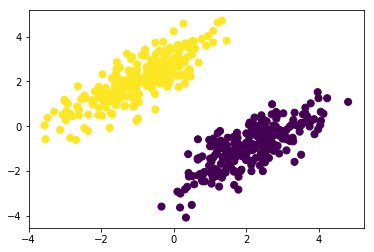

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(X[:,0], X[:,1], s=50, c=y, marker='o')

## SVM のクラスのコーディング

In [19]:
class ScratchSVM:
    def __init__(self, num_iter, lr):
        self.iter = num_iter
        self.lr = lr
        self.y_label = []
        self.sv_lt = []
        self.a_sv = []        

    def fit(self, X, y):
        # ラグランジュ係数
        a = np.random.rand(len(X), 1)
        
        # 各ラベルのサポートベクターが見つかるまでループ
        for num in range(self.iter):
            # データ数分ループ
            for i in range(len(X)):
                temp = 0
                for j in range(len(X)):
                    temp += a[j]*y[i]*y[j]*np.dot(X[i].T, X[j])
                # ラグランジュ係数更新式
                a[i] = a[i] + self.lr * (1 - temp)
                # ラグランジュ係数がマイナスの場合
                if(a[i] < 0):
                    a[i] = 0
        # サポートベクター判定
        self.a_sv = a[a >= 1e-5]
        # 閾値以上のラグランジュ乗数のインデックスを取得
        index_sv = np.where(a >= 1e-5)[0]
        # ラベル取得
        self.y_label = y[index_sv]
        # サポートベクター取得
        self.sv_lt = X[index_sv]       
        
    def predict(self, X):
        # 推定
        f_x = 0
        for i in range(len(self.sv_lt)):
                f_x = f_x + self.a_sv[i] * self.y_label[i] * np.dot(X, self.sv_lt[i].T)
        return f_x

## 識別境界可視化関数

In [40]:
from matplotlib.colors import ListedColormap

# 可視化関数
def plot_decision_regions(X, model):
    plt.scatter(X[:,0], X[:,1], s=80, c=y, marker='o')
    #print(model.sv_lt)
    for sv in model.sv_lt:
        plt.scatter(sv[0], sv[1], s=80, c='c', marker='o')
    
    #サポートベクターも同様にプロット
    step = 0.1
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    pred = model.predict(mesh).reshape(mesh_f0.shape)
    plt.contour(mesh_f0, mesh_f1, pred, 1)
    plt.show()

## 実行

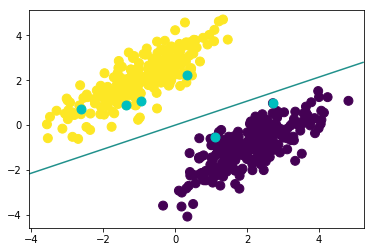

In [41]:
c_svm = ScratchSVM(10, 1e-2)
c_svm.fit(X, y)
plot_decision_regions(X, c_svm)

# 前提知識
## SVMとは

サポートベクターマシン（SVM）は、1995年頃にAT&TのV.Vapnikが発表したパターン識別用の教師あり機械学習方法であり、局所解収束の問題が無い長所がある。<br>
「マージン最大化」というアイデア等で汎化能力も高め、現在知られている方法としては、最も優秀なパターン識別能力を持つとされている。</br>
また、カーネル・トリックという魔法のような巧妙な方法で、線形分離不可能な場合でも適用可能になった事で応用範囲が格段に広がり、近年研究が盛んになっている。</br>
しかし、データを2つのグループに分類する問題には優れているが、多クラスの分類にそのまま適用出来ず、計算量が多い、カーネル関数の選択の基準も無い等の課題も指摘され、一概に誤差逆伝播法等と比較して優れていると言い切れるものでもない。</br>
SVMは厳密にはニューラルネットワークではないが、中間層から出力層への結合係数に該当するものを計算し、ニューラルネットワークと関連付けられる場合も多い。

## SVMにおけるカーネルとは
これまでのサポートベクターマシーン分離面が超平面であることを前提としていました。しかし、実際の問題では正例データと負例データの境界が超平面であるよりは、複雑に入り組んだ超曲面である可能性が高いことが想定される。</br>
このようなデータに、これまで述べてきたようなクラス境界を超平面とするサポートベクターマシーンを適用しても、高い分類性能を期待することは難しい。</br>
たとえば下図のような単純なケースでさえ正例データ（○）と負例データ（×）を分ける直線は存在しないため、１００％の分類性能は達成できない。</br>

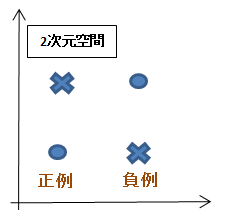

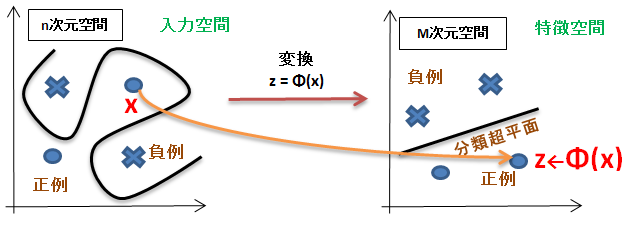

In [10]:
from IPython.display import Image, display_png
# png_file: str
display_png(Image("/home/hiro/デスクトップ/1.png"))
display_png(Image("/home/hiro/デスクトップ/2.png"))

しかし、このようなデータでも線形分離が可能になるような別の空間へ変換できれば、変換先の空間ではクラス境界が超平面になるのでサポートベクターマシーンを用いることが可能になる（上図参照）。元のデータが存在する空間のことを入力空間、変換先の空間のことを特徴空間という。一般的に入力空間の次元nより特徴空間の次元$M$の方が大きくなる（同じ場合もある）。</br>
入力空間のデータ$x$から特徴空間のデータ$z$へ写像する関数$ϕ(x)$とすると$z$は</br>
$$\begin{align} 
z&=(z_1,\ldots,z_M)^T\\ 
&=(\phi_1(x),\ldots,\phi_M(x))^T 
\end{align}$$
と表現できるので、変換後のデータzに対してソフトマージンサポートベクターマシンを適用する。このように非線形のデータに対して、線形にするのがサポートベクターマシンでのカーネルの役割である。

## 線形回帰やロジスティック回帰との比較
線形回帰は数値データに対して予測モデルを作成する。そのため、入力された数値データに対しての予測が可能である。しかし、ロジスティック回
帰やSVMのような分類問題には適応ができない。
### ロジスティック回帰、SVMが得意な分布
#### ロジスティック回帰
ロジスティック回帰分析では、2つのデータ群は、だいたい分かれますが、集まってはいない。 また、正規分布の仮定がない。</br>
ロジスティック回帰分析は、「だいたい」というのを、確率を使って数値で表現できる。</br>
例えば、ほとんどの領域でＡの発生率が０で、一部の領域で最大で発生率が0.1になるような分布をしている場合、 パターン認識では、判別結果はすべてBになる。 多くの手法は、それ以上はわからないのですが、ロジスティック回帰分析では、低い確率では発生する事を扱える。 

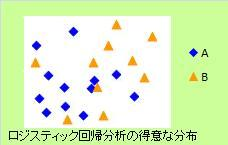

In [13]:
from IPython.display import Image, display_png
# png_file: str
display_png(Image("/home/hiro/デスクトップ/mt3-j.png"))

#### ロジスティック回帰
判別分析に適した分布は、サポートベクターマシンにも適してる。 しかも、正規分布していなくても大丈夫。</br>
ロジスティック回帰分析との違いは、片方のデータ群の表れ方が0.5以上の領域がないと、エラーになることである。 

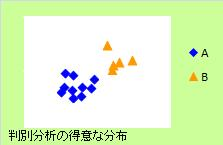

In [14]:
from IPython.display import Image, display_png
# png_file: str
display_png(Image("/home/hiro/デスクトップ/mt1-j.png"))

## ハードマージンSVMとソフトマージンSVMの違い
### ハードマージン
AかBかをはっきり分けられることを前提としたマージンをハードマージンと呼ぶ。</br>
マージン：判別する境界線とデータの距離 </br>
だが、下記のようにどうしても誤判別してしまうデータに対して無理やり「 100 % 正確な判別」をしてしまうと貴重な判別特徴を見失ってしまい、
正しい分類規則が崩れ、予測の精度が下がってしまうことがある。

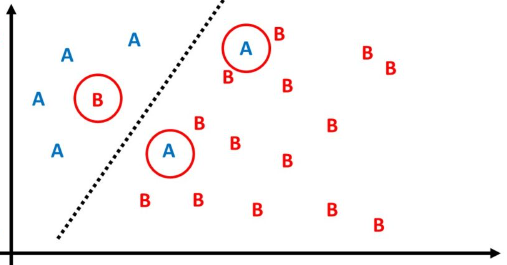

In [16]:
from IPython.display import Image, display_png
# png_file: str
display_png(Image("/home/hiro/デスクトップ/soft.png"))

このように、</br>
教師データ ( 手持ちのデータ ) に対して無理に整合性を高め、</br>
テストデータ ( 未知のデータ ) への予測精度が下がってしまう問題を</br>
過学習という。</br>
### ソフトマージン
過学習せずに予測ができることを汎化性といい、この汎化性を高める為に、あえて誤分類を許容するようにする。誤判別を許容する前提としたマージンをソフトマージンという。</br>
ソフトマージンは「境界線とデータはなるべく最小・誤判別は少なく」を満たす為に、以下の値を最小にするようにする。</br>

$$min\{ \frac{1}{マージン(サポートベクトルと境界線の距離)} +C \times 呉判別数\}$$

パラメータ「 C 」というのは、誤判別をどこまで許容するかを表わす。C が大きければ誤判別を許さず、小さいと誤判別を許容する。C が無限大に大きければ、誤判別は 1 回も許容しないという制約になり実質ハードマージンと変わらなくなる。

</br>
</br>
C はあらかじめ決めておく必要がある。あらかじめ与えられていることが前提のパラメータを、ハイパーパラメータという。

C は適当に決めるか、グリッドサーチなどを使用して「もっとも予測精度が高くなるようにパラメータを調節する」技術もある。
なお、ソフトマージンの場合は識別されたデータに関してもサポートベクトル ( 識別境界線を決める要素 ) だとみなす。

## SVMの学習時と推定時の計算時間について
今回実装した方法では学習時では各特徴の相関を全てとり、特徴数のラグランジュ乗数分回す必要がある。そのため、かなりの時間を必要とする。推定時はサポートベクター数分だけループさせればよいので、学習時ほど時間が掛からない。</br>
効率を上げるためにループ部分を行列化させる必要がある。

## scikit-learnのGridSearchCVの役割について
GridSearchCVの役割は最適なハイパーパラメータを探すことである。
ハイパーパラメータの調整のために、グリッドサーチを組み。
グリッドサーチで調整したいハイパーパラメータを定義して、GridSearchの中に入れる。
更に、交差検証（Cross-Validation）により汎化性能を評価する。
モデルによっては過剰適合して未知のデータの予測精度が落ちることもあるので、データを分割して例えば8割りでモデル構築、残り2割りで評価というプロセスを繰り返す。
これにより、最も確からしいハイパーパラメータを選ぶことが出来る。